In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    confusion_matrix
)

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
from sklearn import model_selection

## Data import

In [3]:
df = pd.read_csv("../credit_risk_dataset_red_ml_ord.csv")

# scaled
#df = pd.read_csv("credit_risk_dataset_red_ml_ord_scaled.csv")

In [4]:
# Train/test set
label = df['loan_status'] # labels
features = df.drop('loan_status',axis=1) # features
x_train, x_test, y_train, y_test = model_selection.train_test_split(features, label, 
                                                                    random_state=42, test_size=.30)

x_all = features
y_all = label

## Auxiliary functions

In [5]:
def create_prediction_df(model, X, y):
    """
    Creates a DataFrame containing the actual labels, model predictions, 
    and the confidence (probability) of the predicted class.

    Parameters:
    - model: A trained estimator (must have .predict(), ideally .predict_proba())
    - X: Input features (DataFrame or array-like)
    - y: True labels (Series or array-like)

    Returns:
    - pd.DataFrame with columns: ['y_true', 'y_pred', 'confidence']
    """
    
    # 1. Generate Predictions
    predictions = model.predict(X)
    
    # 2. Initialize the DataFrame
    # We use valid indices from y if it's a pandas object, otherwise default
    index = y.index if hasattr(y, 'index') else None
    results_df = pd.DataFrame({
        'y_true': y,
        'y_pred': predictions
    }, index=index)
    
    # 3. Calculate Confidence (if supported)
    if hasattr(model, "predict_proba"):
        # Get probabilities for all classes
        probas = model.predict_proba(X)
        
        # Extract the maximum probability for each row (the confidence of the chosen class)
        # axis=1 finds the max value across columns for each row
        confidence = np.max(probas, axis=1)
        
        results_df['confidence'] = confidence
    else:
        # Fallback for models that don't support probabilities (e.g., SVM without probability=True)
        results_df['confidence'] = np.nan
        print("Warning: Model does not support 'predict_proba'. Confidence set to NaN.")

    return results_df

In [6]:
def evaluate_classification(model, X, y):
    """
    Calculates accuracy, F1, precision, recall, support, and confusion matrix.

    Parameters:
    - model: The trained classification model (must have a .predict() method).
    - X: The features to predict on.
    - y: The true labels.

    Returns:
    - metrics: A dictionary containing 'accuracy' and 'confusion_matrix'.
    - report_df: A pandas DataFrame containing precision, recall, f1-score, and support per class.
    """
    # 1. Generate Predictions
    y_pred = model.predict(X)

    # 2. Calculate Metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # 3. Calculate Precision, Recall, F1, and Support
    # precise_recall_fscore_support returns lists for each class
    precision_l, recall_l, f1_l, support_l = precision_recall_fscore_support(y, y_pred)

    # 4. Create a DataFrame for per-class metrics
    # We attempt to use model.classes_ if available for row names, otherwise simple indices
    try:
        classes = model.classes_
    except AttributeError:
        classes = list(range(len(precision_l)))

    report_df = pd.DataFrame({
        'Precision': precision_l,
        'Recall': recall_l,
        'F1-Score': f1_l,
        'Support': support_l
    }, index=classes)

    # 5. Calculate Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)

    
    y_proba = model.predict_proba(X)[:, 1]

    # 6. ROC AUC Score
    # Measures ability to distinguish between classes. 1.0 is perfect, 0.5 is random guessing.
    roc_auc = roc_auc_score(y, y_proba)

    # Bundle everything into a dictionary
    metrics = {
        "accuracy": accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        "confusion_matrix": conf_matrix,
        "roc_auc": roc_auc
    }


    print(report_df)

    for key in metrics.keys():
        print(key, metrics[key])
        
    print(conf_matrix)

    prediction_df = create_prediction_df(model, X, y)

    df_confidence = pd.concat([X, prediction_df['confidence']], axis=1)

    return metrics, report_df, prediction_df, df_confidence

In [7]:
def get_confidence_stats(df):
    """
    Returns a summary table with mean, min, and max confidence 
    for correct vs. incorrect predictions.
    """
    # Create a copy to avoid modifying the original dataframe
    df_stats = df.copy()
    
    # Create a boolean column for grouping
    df_stats['prediction_status'] = df_stats.apply(
        lambda row: 'Correct' if row['y_true'] == row['y_pred'] else 'Incorrect', 
        axis=1
    )
    
    # Group by the status and calculate statistics on the 'confidence' column
    summary = df_stats.groupby('prediction_status')['confidence'].agg(['mean', 'std', 'min', 'max', 'count'])
    
    return summary

In [8]:
def lowest_x_confidence(df, x):

    return df.nsmallest(x, 'confidence')

## XGBoost train

In [9]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) 

xgb_model.fit(x_train, y_train)

# Substitute as you want x_train, y_train; x_test, y_test; x_all y_all
metrics, report_df, prediction_df, df_confidence = evaluate_classification(xgb_model, x_all, y_all)


   Precision    Recall  F1-Score  Support
0   0.976131  0.993606  0.984791     2346
1   0.975490  0.912844  0.943128      654
accuracy 0.976
Precision 0.9754901960784313
Recall 0.9128440366972477
F1-Score 0.943127962085308
confusion_matrix [[2331   15]
 [  57  597]]
roc_auc 0.9801829387518869
[[2331   15]
 [  57  597]]


In [10]:
selected_features = [
    "person_home_ownership_RENT",
    "loan_grade",
    "loan_percent_income",
    "person_home_ownership_OWN",
    "person_home_ownership_MORTGAGE",
    "loan_intent_DEBTCONSOLIDATION",
    "loan_int_rate",
    "loan_intent_HOMEIMPROVEMENT",
    "loan_intent_MEDICAL",
    "loan_amnt",
    "loan_status"
]

update_df = df[selected_features]
df_confidence_prova = pd.concat([update_df, prediction_df['confidence']], axis=1)
print(len(df_confidence_prova))

3000


In [11]:
number_of_points_from_which_to_balance = 400

lowest = lowest_x_confidence(df_confidence_prova, number_of_points_from_which_to_balance)
# THIS IS UNBALANCED 

counts = lowest["loan_status"].value_counts()
n_min = counts.min()

lowest_balanced = ( 
    pd.concat([
        lowest[lowest["loan_status"] == 0 ].sample(n = n_min, random_state=42), 
        lowest[lowest["loan_status"] == 1 ].sample(n = n_min, random_state=42), 
        ])
        .sample(frac=1, random_state = 42)
        .reset_index(drop=True)
)
lowest_balanced["loan_status"].value_counts()


loan_status
0    195
1    195
Name: count, dtype: int64

In [12]:
lowest_balanced.to_csv('name_of_file.csv', index=False)

In [37]:
f1_scores_classical = []
f1_scores_quantum = []

In [18]:
X_paolo = lowest_balanced.drop(columns=['loan_status', 'confidence']).values
y_paolo = lowest_balanced['loan_status'].values

In [15]:
from sklearn.model_selection import train_test_split
import xgboost

In [ ]:
for iteration in range(10):
    random_number = np.random.randint(0, 1000)
    # Split by percentage
    train_percentage = 0.8  # 80% train, 20% test
    X_train_inside, X_test_inside, train_labels_inside, test_labels_inside = train_test_split(
        X_paolo, y_paolo, train_size=train_percentage, random_state=random_number, shuffle=True
    )

    print(f"Training classical, random_state {random_number}:")

    xgb_model = xgboost.XGBClassifier(objective = "binary:logistic", random_state=42)
    xgb_model.fit(X_train_inside, train_labels_inside)
    y_pred = xgb_model.predict(X_test_inside)
    f1_scores_classical.append(f1_score(test_labels_inside, y_pred))



    # Step 3: create scaler
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    # Step 4: fit scaler on your training set or just transform this vector
    X_train_inside = scaler.fit_transform(X_train_inside.astype(float))  # or scaler.transform(x_array) if already fitted
    X_test_inside = scaler.fit_transform(X_test_inside.astype(float))

    X_train_inside = [row.tolist() for row in X_train_inside]
    X_test_inside = [row.tolist() for row in X_test_inside]

    train_labels_inside = [row.tolist() for row in train_labels_inside]
    test_labels_inside = [row.tolist() for row in test_labels_inside]

    from qiskit.circuit.library import zz_feature_map
    from qiskit.quantum_info import SparsePauliOp
    from qiskit_ibm_runtime import EstimatorV2 as Estimator
    from qiskit.primitives import StatevectorEstimator
    
    print(f"Training quantum, random_state {random_number}:")

    n_qubits = len(X_train_inside[0])  # e.g., 10
    feature_map = zz_feature_map(feature_dimension=n_qubits,entanglement='linear', reps=2)
    #feature_map.draw("mpl")

    lista_observables = []

    print(f"Creating correlators, random_state {random_number}:")

    for i in range(n_qubits):
        obs = SparsePauliOp.from_sparse_list(
            [("Z", [i], 1.0)],
            num_qubits=n_qubits
        )
        lista_observables.append(obs)


    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            pauli_str = ['I'] * n_qubits
            pauli_str[i] = 'Z'
            pauli_str[j] = 'Z'
            obs = SparsePauliOp(''.join(pauli_str))
            lista_observables.append(obs)
    estimator = StatevectorEstimator()
 
    X_train_inside_fan_out = []
    X_test_inside_fan_out = []    

    for i in X_train_inside:   
        circuit = feature_map.assign_parameters(i)
        pub = (
        circuit,  # ISA circuit
        lista_observables
        )
        job_result = estimator.run(pubs=[pub]).result()[0]

        nex_X_point = job_result.data.evs
        X_train_inside_fan_out.append(nex_X_point)

    for i in X_test_inside:   
        circuit = feature_map.assign_parameters(i)
        pub = (
        circuit,  # ISA circuit
        lista_observables
        )
        job_result = estimator.run(pubs=[pub]).result()[0]

        nex_X_point = job_result.data.evs
        X_test_inside_fan_out.append(nex_X_point)


    X_train_inside_fan_out = np.array(X_train_inside_fan_out)
    X_test_inside_fan_out = np.array(X_test_inside_fan_out)

    print(f"Train a new classical model on the quantum features, random_state {random_number}:")

    xgb_model_new = xgboost.XGBClassifier(objective = "binary:logistic", random_state=42)
    xgb_model_new.fit(X_train_inside_fan_out, train_labels_inside)
    y_pred_new = xgb_model_new.predict(X_test_inside_fan_out)
    f1_scores_quantum.append(f1_score(test_labels_inside, y_pred_new))



Training classical, random_state 19:
Training quantum, random_state 19:
Creating correlators, random_state 19:
Train a new classical model on the quantum features, random_state 19:
Training classical, random_state 271:
Training quantum, random_state 271:
Creating correlators, random_state 271:
Train a new classical model on the quantum features, random_state 271:
Training classical, random_state 801:
Training quantum, random_state 801:
Creating correlators, random_state 801:
Train a new classical model on the quantum features, random_state 801:
Training classical, random_state 454:
Training quantum, random_state 454:
Creating correlators, random_state 454:
Train a new classical model on the quantum features, random_state 454:
Training classical, random_state 286:
Training quantum, random_state 286:
Creating correlators, random_state 286:
Train a new classical model on the quantum features, random_state 286:
Training classical, random_state 150:
Training quantum, random_state 150:
Creat

In [71]:
f1_scores_classical

[0.4819277108433735,
 0.3684210526315789,
 0.525,
 0.410958904109589,
 0.475,
 0.26666666666666666,
 0.4383561643835616,
 0.4810126582278481,
 0.4810126582278481,
 0.49411764705882355,
 0.3287671232876712,
 0.43037974683544306,
 0.5185185185185185,
 0.5,
 0.410958904109589,
 0.47368421052631576,
 0.4155844155844156,
 0.5176470588235295,
 0.4,
 0.5060240963855421,
 0.5128205128205128,
 0.4533333333333333,
 0.33766233766233766,
 0.43243243243243246,
 0.4935064935064935,
 0.5176470588235295,
 0.5609756097560976,
 0.3235294117647059,
 0.475,
 0.2571428571428571,
 0.5897435897435898]

In [72]:
f1_scores_quantum

[0.5066666666666667,
 0.4935064935064935,
 0.547945205479452,
 0.4507042253521127,
 0.5316455696202531,
 0.4864864864864865,
 0.3888888888888889,
 0.5116279069767442,
 0.5116279069767442,
 0.3611111111111111,
 0.5,
 0.38961038961038963,
 0.3611111111111111,
 0.4675324675324675,
 0.4050632911392405,
 0.6133333333333333,
 0.4578313253012048,
 0.45,
 0.5205479452054794,
 0.36619718309859156,
 0.47368421052631576,
 0.43478260869565216,
 0.39473684210526316,
 0.46153846153846156,
 0.6341463414634146,
 0.525,
 0.46153846153846156,
 0.43478260869565216,
 0.5316455696202531,
 0.4225352112676056,
 0.5185185185185185]

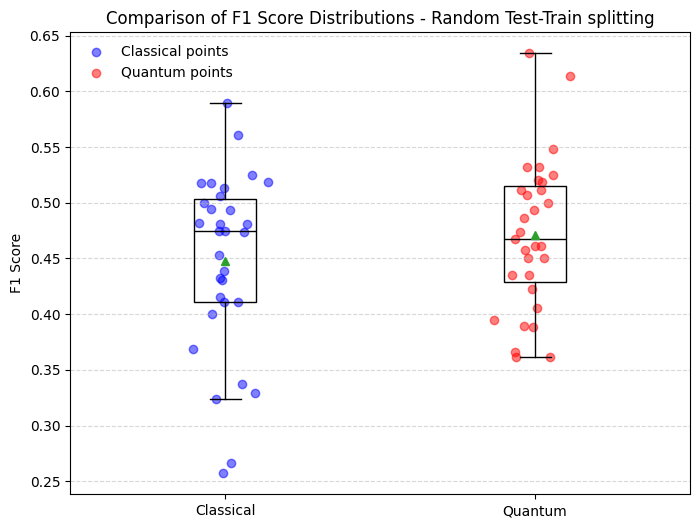

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
# f1_scores_classical = [...]
# f1_scores_quantum = [...]

x_pos = [0, 1]
data = [f1_scores_classical, f1_scores_quantum]
# Create figure with transparent background
plt.figure(figsize=(8,6), facecolor='none')  # figure background transparent

# Boxplot with transparent fill and thick edges
box = plt.boxplot(data, positions=x_pos, patch_artist=True, widths=0.2,  showfliers=False, showmeans = True)

colors = ['skyblue', 'lightcoral']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor("None")

# Customize whiskers, caps, and median
for whisker in box['whiskers']:
    whisker.set_color('black')
for cap in box['caps']:
    cap.set_color('black')
for median in box['medians']:
    median.set_color('black')


# Overlay points with jitter
jitter_strength = 0.05

plt.scatter(np.random.normal(x_pos[0], jitter_strength, len(f1_scores_classical)), f1_scores_classical, 
            color='blue', alpha=0.5, label='Classical points')
plt.scatter(np.random.normal(x_pos[1], jitter_strength, len(f1_scores_quantum)), f1_scores_quantum, 
            color='red', alpha=0.5, label='Quantum points')

# Transparent axes background
plt.gca().patch.set_alpha(0.0)  # make axes background transparent

# Labels and title
plt.xticks(x_pos, ['Classical', 'Quantum'])
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Score Distributions - Random Test-Train splitting')
plt.legend(framealpha=0.0)  # 0 = fully transparent, 1 = opaque
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save figure with transparent background (optional)
plt.savefig('f1_boxplot-linear-2-reps.png', transparent=True)

plt.show()
